# Calculator: The Game <br> <font style='font-size:15px;'>A Reinforcement Learning approach</font>

<font style='font-size=12px'>Elijah Justin Medina</font>

## Highlights
- Reinforcement Learning can be used to identify the steps to take in order to process an integer to another desired integer.
- The rules and rewards heavily affect the convergence of the learner and the optimal string of operations to perform on the agent.
- Given the current methodology (Q-Learning), this project cannot be scaled to Python objects that can take infinite number of states.

## Problem Statement

Data wrangling is a very tedious process, especially for those with minimal experience on programming. Most of the time, they would have an idea of what the form of their desired output is but at a loss on how to get there from the input data. For example,

<img src="prob_statement1.png" width=60%>

Given an arbitrary Python object like a pandas Dataframe (read from a CSV), they would have to perform a string of operations to reach a desired outcome. If this desired outcome can be manually written, machine learning models can be used to map the input to the output. However, the process and steps to get there will remain a blackbox using traditional machine learning or even deep learning techniques. Our approach to this problem is the use of reinforcement learning wherein the agent is the Python object and the actions it takes are Python methods, changing its state until it becomes similar to the target output.

As an initial study, we start this project with **wrangling Python integers to a desired Python integer**. From this, we examine the feasibility of the project using Tabular Q-Learning and of further scaling it into other Python objects.

## Introduction

One direct application of this project is finding the solution to Calculator: The Game, a game wherein there is a given input number, a target output number, and a set of actions that can be done on the number.

<img src="calc_thegame.jpg" width=25%>

Given the number `2`, the player is restricted to the actions `\3` (divide by 3), `1 [violet]` (append 1 to the number), `x2` (multiply by 2), and `4=>5` (convert all 4s to 5s), to change the value to the target `15` in 4 moves.

## Methodology

In reinforcement learning, before anything else, the agent, actions, environment, observations, and corresponding rewards must be defined first.

**Agent**

The agent in this problem is the Python integer that is being processed. It can take different states limited to integers ranging from -500 to 500 (the limit was set to minimize the number of states our agent can take)

**Actions**

Hypothetically, the actions that the agent can take are all Python methods but for this project, there are four main actions: addition, subtraction, multiplication, or (integer) division with a number. For each main action, the number to add, subtract, multiply, or divide our agent with can vary. In this project, this number can take values from 1 to 9 for the addition/subtraction and prime numbers from 2 to 5 for the multiplication/division. The probabilities of taking each main actions is equal but the number to use has probabilities weighted by their inverse for the addition/subtraction and frequency for multiplication/division. These probabilities are plotted below:

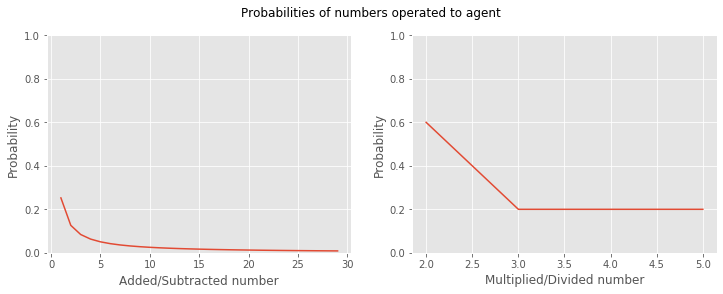

In [48]:
probs = 1/np.arange(1, 10)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.arange(1, 10), probs/sum(probs))
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Added/Subtracted number')
ax[0].set_ylabel('Probability')

# prime factors for probs of mult

primes = []
for n in range(2, 6):
    i = 1
    while i <= n:
        while n%i == 0:
            n = n/i
            if i!=1:
                primes.append(i)
            #Avoid infinite loops which only happens when i = 1 in this case.
            if n == n/i: 
                break
        i += 1

primes, freq = np.unique(primes, return_counts=1)
probs_primes = freq/sum(freq)

ax[1].plot(primes,probs_primes)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Multiplied/Divided number')
ax[1].set_ylabel('Probability')
fig.suptitle("Probabilities of numbers operated to agent");

**Observations**

The observations of the agent here is constrained to where the agent's state currently is. For some of the rules implemented below, the agent can also observe if the certain action it took makes it nearer or farther to the target.

**Rewards**

The set of rewards for actions is varied, the effect of which on convergence to a solution is explored.

1. Rule 1
    - Reached the goal number: +10
    - Reached a boundary: -1000
    - Got closer to target: +0.1
    - Got farther from target: -1.1
2. Rule 2
    - Reached the goal number: +10
    - Reached a boundary: -1000
    - Walk: -0.2
3. Rule 3
    - Reached the goal number: +10
    - Reached a boundary: -1000
    - Got closer to target: +0.5
    - Got farther from target: -0.2

Five trials were performed for each rule set.

**Q-Learning**

The algorithm used for this project is Tabular Q-Learning wherein a table of all possible states (rows) and all possible actions (columns) is created. The values are filled with the discounted future rewards, i.e. how "profitable" is it to take a certain action (column) given your current state (row). The update rules for for this Q-value is:

$$Q^{new}(s_t, a_t) = (1 - \alpha) \cdot \underbrace{Q(s_t, a_t)}_{\text{old value}} + \underbrace{\alpha}_{\text{learning rate}} \cdot \overbrace{\left(\underbrace{r_t}_{\text{reward}} + \underbrace{\gamma}_{\text{discount factor}} \cdot \underbrace{\max_a Q(s_{t+1}, a)}_{\text{estimate of optimal future value}}\right)}^{\text{learned value}}$$

In reinforcement learning, the action taken at each step can be one of two things: exploration or exploitation. Exploration is the completely random choice of which action to take while exploitation is taking the best next action based on the Q-Learning table. The chance of choosing exploration over exploitation ($\epsilon$) starts at 100% (pure exploration) and decays by 0.001% every 50 iterations. This is done until the 1M iteration at which point the final Q-Learning table is saved. Whenever it reaches the target output, the value reverts back to the initial value and resumes the iterations.

If all states are explored, there will be 999 total possible states or rows (from -499 to 499) and 24 total possible actions or columns (9(add)+ 9(subtract) + 3(multiply) + 3(divide)) for the table.

## Results and Discussion

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

# import sys
# !{sys.executable} -m pip install stable-baselines[mpi]==2.8.0
# !conda install -c conda-forge --yes --prefix {sys.prefix} keras
# !conda install -c conda-forge --yes --prefix {sys.prefix} dash
# !conda install -c conda-forge --yes --prefix {sys.prefix} openmpi

### Rule 1
Reward rules:
    - Reached the goal number: +10
    - Reached a boundary: -1000
    - Got closer to target: +0.1
    - Got farther from target: -1.1
    
With these rules, in any state, the agent can observe where the target value is, rewarding when it gets closer to it and suffering a penalty if it goes farther from the target.

In [50]:
init_state = 5

out_state = 63


def add(x, num=None, max_add=10):
    if num:
        added_num = num
    else:
        probs = 1/np.arange(1, max_add)
        added_num = np.random.choice(np.arange(1, max_add), p=probs/sum(probs))
    return (x + added_num, f'add:{added_num}')

def subtract(x, num=None, max_sub=10):
    if num:
        sub_num = num
    else:
        probs = 1/np.arange(1, max_sub)
        sub_num = np.random.choice(np.arange(1, max_sub), p=probs/sum(probs))
    return (x - sub_num, f'subtract:{sub_num}')

def mult(x, num=None, primes=primes, probs=probs_primes):
    if num:
        mult_num = num
    else:
        mult_num = np.random.choice(primes, p=probs)
    return (x * mult_num, f'mult:{mult_num}')

def div(x, num=None, primes=primes, probs=probs_primes):
    if num:
        div_num = num
    else:
        div_num = np.random.choice(primes, p=probs)
    return (round(x / div_num), f'div:{div_num}')
    
actions = ['add', 'subtract', 'mult', 'div']
move = {'add': add,
        'subtract': subtract,
        'mult': mult,
        'div': div}

## set agent learning
discount = 0.9
learning_rate = 0.5
eps = 1#0.99
decay_eps = 0.99


## set rewards
s_rew = 10
f_rew = -100
partial_s_rew = 0.6
partial_f_rew = -0.6
wall_hit_rew = -1000
walk_rew = -0.5

def rewards(new_val, out_state, curr_state, s_rew, walk_rew):
    if new_val==out_state:
        reward = s_rew
    elif (new_val > 500) or (new_val < -500):
        reward = wall_hit_rew
    elif abs(out_state - new_val) < abs(out_state - curr_state):
        reward = partial_s_rew + walk_rew
    elif abs(out_state - new_val) >= abs(out_state - curr_state):
        reward = partial_f_rew + walk_rew
#     elif (pos[0], pos[1]) in f_pos:
#         reward = f_rew
#     else:
#         reward = walk_rew
        
    return reward

In [54]:
iterss = []
for trial in range(4):
    print(f"=============Trial {trial}=============")
    Qs = pd.DataFrame(dtype=float)
    curr = init_state
    eps = 1
    decay_eps = 0.999
    iters=0
    iter_per_convergence = []
    max_iter = 1000

    for i in range(int(1e6)):
        if (np.random.random() > eps): #exploit
            Q_state = Qs.loc[str(curr), :]
            Q_max = Q_state.max()
            max_acts = list(Q_state[Q_state==Q_max].index)
            action_name = np.random.choice(max_acts)
            action, num = action_name.split(':')
        else: #explore
            action = np.random.choice(actions)
            num = 0
    #     print(action)
        try:
            new_val, action_name = move[action](curr, num=int(num))
    #         print(action, action_name)
            reward = rewards(new_val, out_state, curr, s_rew, walk_rew)
        except Exception as e:
            print("ERROR. Give punishment")
            new_val = curr
            reward = f_rew


        try:
            Qs.loc[str(curr), action_name]
        except KeyError:
            Qs.loc[str(curr), action_name] = 0

        try:
            Qs.loc[str(int(new_val)), action_name]
        except KeyError:
            Qs.loc[str(int(new_val)), action_name] = 0

        Qs.loc[str(curr), action_name] += learning_rate * (reward
                                                 + discount * Qs.loc[str(int(new_val)), :].max()
                                                 - Qs.loc[str(curr), action_name])
        if (new_val > 500) or (new_val < -500) or (new_val==out_state) or (iters>=max_iter):
            if new_val==out_state:
                iter_per_convergence.append(iters)
                iters = 0
            if iters>=(max_iter):
                iters = 0
            curr = init_state
        else:
            curr = int(new_val)
        if i%50==0:
            eps *= decay_eps
        iters+=1
    Qs.to_parquet(f"solutions/q-table-rule1-T{trial}.parquet")
    iterss.append(iter_per_convergence)

=============Trial 0=============
=============Trial 1=============
=============Trial 2=============
=============Trial 3=============


#### Number of iterations to converge

Out of the 5 trials, only one trial properly found the optimal solution in a few steps. The plot below shows how many iteration it takes for each convergence. The x-range of the plot shows the total number of convergence that occured for that trial in 1M iterations (which is the reason why ranges vary from trial to trial). Note however that as you go through the later iterations, the agents performs exploitation more frequently than exploration, so if the number of iterations to converge decreases as x increases, the Q-Learning table is optimized to find the solution in minimum number of steps. This is not the case for the following trials:

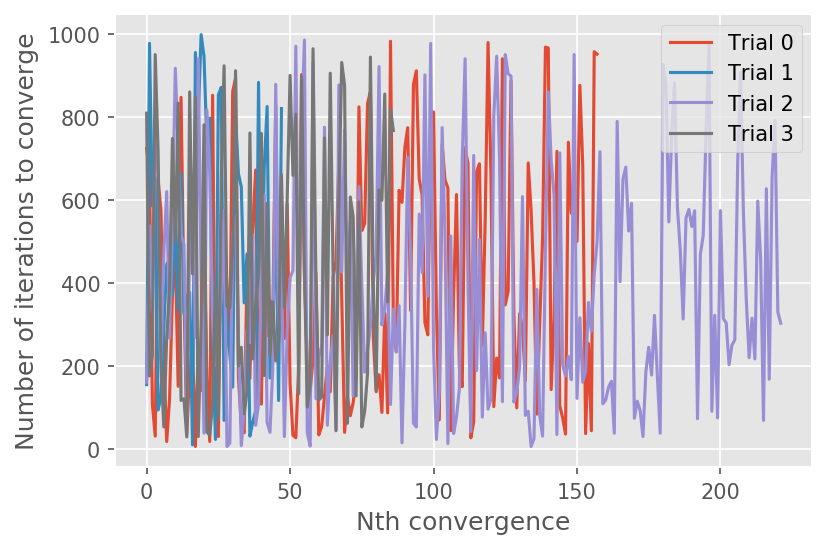

In [55]:
plt.style.use('ggplot')
plt.figure(dpi=150)
i = 0
for iter_per_convergence in iterss:
    plt.plot(iter_per_convergence, label=f'Trial {i}')
    i+=1
plt.xlabel("Nth convergence")
plt.legend()
plt.ylabel("Number of iterations to converge");

For one trial, an optimal solution was found:

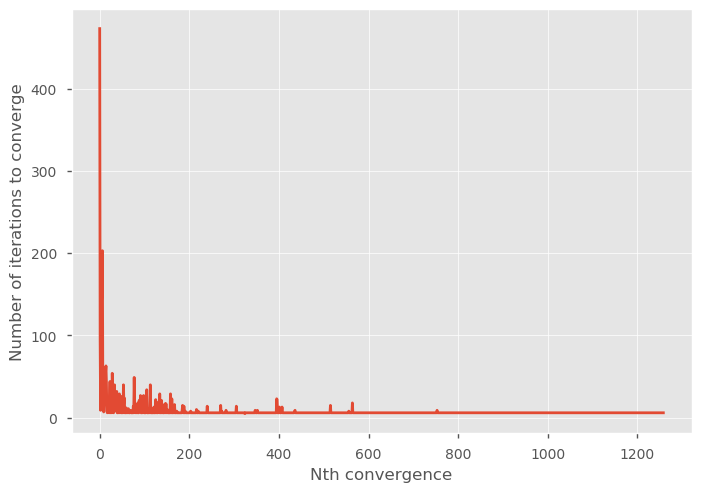

In [41]:
# iter_per_convergence_converged = iter_per_convergence
plt.style.use('ggplot')
plt.plot(iter_per_convergence_converged)
plt.xlabel("Nth convergence")
plt.ylabel("Number of iterations to converge");

The decreasing number of iterations to converge indicates that RL has found the solution in minimum steps. The found solution is shown below:

#### Solution

In [36]:
#input 5
val = 5
while val!=out_state:
    act, num = Qs_fixed_start.loc[str(val)].idxmax().split(':')
    val, act_num = move[act](val, num=int(num))
    print(act_num)
# subtract1 4
# mult2 8
# mult2 16
# mult2 32
# mult2 64
# subtract1 63

subtract:1
mult:2
mult:2
mult:2
mult:2
subtract:1


In this case, the operations performed are only subtraction and multiplication of the lowest numbers. This is to be expected since the probabilities are higher for lower numbers. But more than that, since the agent is rewarded for getting closer and punished for getting farther, regardless of how much it gets closer or farther (same reward), it is easier for the model to operate a smaller number.

### Rule 2
Rules:
    - Reached the goal number: +10
    - Reached a boundary: -1000
    - Walk: -0.2
    
With these rules, the agent can only observe its current state, without any reward or penalty for getting closer or farther from the target.

In [29]:
init_state = 5

out_state = 63

# prime factors for probs of mult

primes = []
for n in range(2, 6):
    i = 1
    while i <= n:
        while n%i == 0:
            n = n/i
            if i!=1:
                primes.append(i)
            #Avoid infinite loops which only happens when i = 1 in this case.
            if n == n/i: 
                break
        i += 1

primes, freq = np.unique(primes, return_counts=1)
probs_primes = freq/sum(freq)

def add(x, num=None, max_add=10):
    if num:
        added_num = num
    else:
        probs = 1/np.arange(1, max_add)
        added_num = np.random.choice(np.arange(1, max_add), p=probs/sum(probs))
    return (x + added_num, f'add:{added_num}')

def subtract(x, num=None, max_sub=10):
    if num:
        sub_num = num
    else:
        probs = 1/np.arange(1, max_sub)
        sub_num = np.random.choice(np.arange(1, max_sub), p=probs/sum(probs))
    return (x - sub_num, f'subtract:{sub_num}')

def mult(x, num=None, primes=primes, probs=probs_primes):
    if num:
        mult_num = num
    else:
        mult_num = np.random.choice(primes, p=probs)
    return (x * mult_num, f'mult:{mult_num}')

def div(x, num=None, primes=primes, probs=probs_primes):
    if num:
        div_num = num
    else:
        div_num = np.random.choice(primes, p=probs)
    return (round(x / div_num), f'div:{div_num}')
    
actions = ['add', 'subtract', 'mult', 'div']
move = {'add': add,
        'subtract': subtract,
        'mult': mult,
        'div': div}

## set agent learning
discount = 0.9
learning_rate = 0.5
eps = 1#0.99
decay_eps = 0.99


## set rewards
s_rew = 10
f_rew = -100
wall_hit_rew = -1000
walk_rew = -0.2

def rewards(new_val, out_state, curr_state, s_rew, walk_rew):
    if new_val==out_state:
        reward = s_rew
    elif (new_val > 500) or (new_val < -500):
        reward = wall_hit_rew
    else:
        reward = walk_rew
        
    return reward

In [30]:
iterss = []
for trial in range(5):
    print(f"=============Trial {trial}=============")
    Qs = pd.DataFrame(dtype=float)
    curr = init_state
    eps = 1
    decay_eps = 0.999
    iters=0
    iter_per_convergence = []
    max_iter = 1000

    for i in range(int(1e6)):
        if (np.random.random() > eps): #exploit
            Q_state = Qs.loc[str(curr), :]
            Q_max = Q_state.max()
            max_acts = list(Q_state[Q_state==Q_max].index)
            action_name = np.random.choice(max_acts)
            action, num = action_name.split(':')
        else: #explore
            action = np.random.choice(actions)
            num = 0
    #     print(action)
        try:
            new_val, action_name = move[action](curr, num=int(num))
    #         print(action, action_name)
            reward = rewards(new_val, out_state, curr, s_rew, walk_rew)
        except Exception as e:
            print("ERROR. Give punishment")
            new_val = curr
            reward = f_rew


        try:
            Qs.loc[str(curr), action_name]
        except KeyError:
            Qs.loc[str(curr), action_name] = 0

        try:
            Qs.loc[str(int(new_val)), action_name]
        except KeyError:
            Qs.loc[str(int(new_val)), action_name] = 0

        Qs.loc[str(curr), action_name] += learning_rate * (reward
                                                 + discount * Qs.loc[str(int(new_val)), :].max()
                                                 - Qs.loc[str(curr), action_name])
        if (new_val > 500) or (new_val < -500) or (new_val==out_state) or (iters>=max_iter):
            if new_val==out_state:
                iter_per_convergence.append(iters)
                iters = 0
            if iters>=(max_iter):
                iters = 0
            curr = init_state
        else:
            curr = int(new_val)
        if i%50==0:
            eps *= decay_eps
        iters+=1
    Qs.to_parquet(f"solutions/q-table-rule2-T{trial}.parquet")
    iterss.append(iter_per_convergence)

=============Trial 0=============
=============Trial 1=============
=============Trial 2=============
=============Trial 3=============
=============Trial 4=============


#### Number of iterations to converge

Out of the 5 trials, one trial (Trial 3) converged properly to an optimal solution.

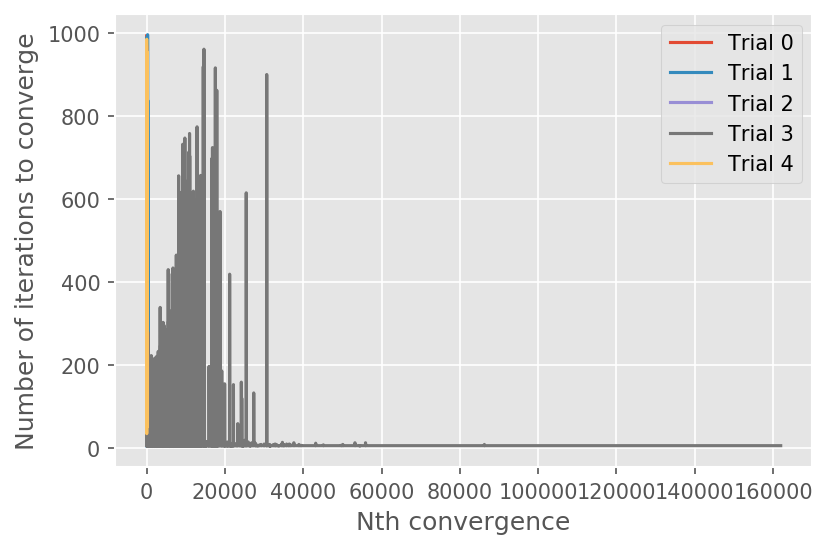

In [43]:

plt.style.use('ggplot')
plt.figure(dpi=150)
i = 0
for iter_per_convergence in iterss:
    plt.plot(iter_per_convergence, label=f"Trial {i}")
    i+=1
plt.legend()
plt.xlabel("Nth convergence")
plt.ylabel("Number of iterations to converge");

Looking at the found solution with Trial 3 (the trial that properly converged)

#### Solution

In [52]:
val = 5
Qs_fixed_start = pd.read_parquet(f"solutions/q-table-rule2-T3.parquet")
i = 0
while ((val!=out_state) and (i<10)):
    act, num = Qs_fixed_start.loc[str(val)].idxmax().split(':')
    val, act_num = move[act](val, num=int(num))
    print(act_num, val)
    i+=1
#     break

div:3 2
div:3 1
add:6 7
mult:3 21
mult:3 63


Unlike with the first rule, the solution found here is not biased towards lower values, which also led to less number of operations to converge (5 operations with this rule vs 6 of Rule 1).

## Summary / Main Learning points

**Convergence**

In both rule sets, most of the trials failed to converge properly. This is due to the fact that there are too many states that our agent can take and too many actions it can take. The reinforcement learner should be given more time to explore (i.e. more iterations and slower decay in probability of exploration) if this is the case. On the first attempt, the project was constrained to floats rather than integers, but this led to infinite possible states. So it becomes impossible for the learner to properly fill the Q-Learning table.

The convergence of the learner is heavily dependent on the first few convergences. If the table is filled with the solution of minimal steps, the latter part of the iterations wherein the agent is mostly purely exploiting always converges with said minimal steps. Alternatively, some trials tend to be stuck to a periodic solution (e.g. it performs the same two operations every time), so an agent purely exploiting won't ever converge as it will only change between two values. 

**Resulting solution**

For Rule 1, the resulting solution is heavily biased towards operating the smallest numbers to the agent (i.e. when adding/subtracted, 1 is usually chosen while 2 is operated for multiplication/division). This is due to two things: the higher probability of the lower values and the consequence of the rules wherein it is rewarded for getting closer and punished for getting further, regardless of how close or how far it became after operating. In essence, the agent learns that it is safer to take smaller steps due to this specific reward.

For Rule 2, there was no bias towards smaller numbers. As a consequence, the learner can also take larger steps since it isn't rewarded or punished for taking the safe actions.

**Limitations and future work**

Q-Learning cannot be used for Python object manipulation if the number of states it can take is infinite. Alternative reinforcement learning techniques or rules for rewards should be explored for this problem. As for scaling the project into different Python objects, it is feasible but the number of actions the agents can do must be clearly defined and the number of states is finite.

## Acknowledgement

I would like to acknowledge Prof Chris and Prof Erika for sharing their knowledge to us which contributed immensely to the completion of this project. More importantly, Dr. Bunao for sharing his knowledge on reinforcement learning techniques, from which the codes here are based on. Lastly, my classmates for the exchange of ideas which helped alot for this project. 

In [56]:
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }
  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')